In [15]:
data_coords = {
    0: (20, 20),
    1: (20, 40),
    2: (20, 160),
    3: (40, 120),
    4: (60, 20),
    5: (60, 80),
    6: (60, 200),
    7: (80, 180),
    8: (100, 40),
    9: (100, 120),
    10: (100, 160),
    11: (120, 80),
    12: (140, 140),
    13: (140, 180),
    14: (160, 20),
    15: (180, 60),
    16: (180, 100),
    17: (180, 200),
    18: (200, 40),
    19: (200, 160)}

data_map = {"Brighton" : {"Brighton": 0, "Bristol": 172, "Cambridge": 145, "Glasgow": 607, "Liverpool": 329,
                          "London": 72, "Manchester": 312, "Oxford": 120},
             "Bristol" : {"Brighton": 172, "Bristol": 0, "Cambridge": 192, "Glasgow": 494, "Liverpool": 209,
                          "London": 158, "Manchester": 216, "Oxford": 92},
             "Cambridge" : {"Brighton": 145, "Bristol": 192, "Cambridge": 0, "Glasgow": 490, "Liverpool": 237,
                          "London": 75, "Manchester": 205, "Oxford": 100},
             "Glasgow" : {"Brighton": 607, "Bristol": 494, "Cambridge": 490, "Glasgow": 0, "Liverpool": 286,
                          "London": 545, "Manchester": 296, "Oxford": 489},
             "Liverpool" : {"Brighton": 329, "Bristol": 209, "Cambridge": 237, "Glasgow": 286, "Liverpool": 0,
                          "London": 421, "Manchester": 49, "Oxford": 408},
             "London" : {"Brighton": 72, "Bristol": 158, "Cambridge": 75, "Glasgow": 545, "Liverpool": 421,
                          "London": 0, "Manchester": 249, "Oxford": 75},
             "Manchester" : {"Brighton": 312, "Bristol": 216, "Cambridge": 205, "Glasgow": 296, "Liverpool": 49,
                          "London": 249, "Manchester": 0, "Oxford": 194},
             "Oxford" : {"Brighton": 120, "Bristol": 92, "Cambridge": 100, "Glasgow": 489, "Liverpool": 208,
                          "London": 75, "Manchester": 194, "Oxford": 0}
            }

# data_coords or data_map
# data = data_coords
data = data_map

# euclid or map
map_data_type = True # for map
# map_data_type = False  # for data coords

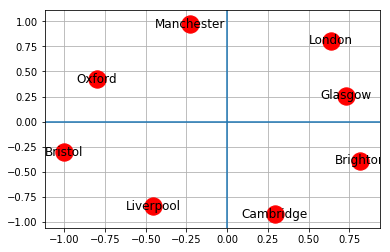

In [16]:
#plot nodes
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.Graph()

if not map_data_type:
    for n, p in data.items():
        graph.add_node(n)
        graph.node[n]['pos'] = p
else:
    for n in data.keys():
        graph.add_node(n)
        
if map_data_type:
    nx.draw_networkx(graph)
else:
    nx.draw_networkx(graph, data)
    
    
plt.axhline(y=0)
plt.axvline(x=0)
plt.grid()
plt.show()

In [17]:
import random as rand

""" generate initial population """
def init_population(n):
    individuals = []
    
    for i in range(n):
        individuals.append(gen_individual())
    
    return individuals

""" generate an individual """
def gen_individual():
    nodes = list(data.keys())
    rand.shuffle(nodes)
    return nodes

""" evaluate an individual by returning its fitness score (1 / path cost)"""
def evaluate(individual):
    cost = 0
    
    # calculate and sum path cost to travel from node to node
    for i in range(0, len(individual)-1):
        n1 = individual[i]
        n2 = individual[i+1]
        cost += dist(n1, n2)
        
    # add cost for return
    start = individual[0]
    end = individual[len(individual)-1]
    cost += dist(end, start)
        
    return 1.0 / cost

""" select top n individuals sorted by their fitness score"""
def select_top(individuals, n):
    scores = [evaluate(i) for i in individuals]
    results = np.array(list(zip(individuals, scores)))
    return results[results[:,1].argsort()[::-1]][:n]

""" select k random individuals and return the one with the highest fitness score """
def tournament_selection(individuals, k):
    selection = rand.choices(individuals, k=k)
    top = select_top(selection, 1)
    return top[0][0]
        
""" ordered crossover """
def crossover(n1, n2):
    
    best, other = n1, n2
    
    if evaluate(n1) < evaluate(n2):
        best, other = other, best
    
    # indices for a random subset from the best individual
    start = rand.randint(0, len(best)-1)
    end = rand.randint(0, len(best)-1)
    
    if(start > end): #swap indices if needed
        start, end = end, start

    if(start == end): #single element
        subset = [best[start]]
        end = end+1
    else: #otherwise return subset
        subset = best[start:end]
    
    # remove those already within the subset
    pruned_other = [x for x in other if x not in subset]
    
    new = []
    
    # perform crossover
    for i in range(0, start):
        new.append(pruned_other.pop(0))
        
    new.extend(subset)
    
    for i in range(end, len(best)):
        new.append(pruned_other.pop(0))
            
    return new

""" swap mutation """
def mutate(individual):
    gene1 = rand.randint(0, len(individual)-1)
    gene2 = rand.randint(0, len(individual)-1)
    
    while True:
        if gene1 == gene2:
            gene2 = rand.randint(0, len(individual)-1)
        else:
            break
            
    new = individual.copy()
            
    new[gene1], new[gene2] = new[gene2], new[gene1]
    
    return new

def evolve(_pop, N):
    new_pop = []
    k = 20
    num_elites = 3

    # add previous best to new population to guarantee the fitness cannot get worse
    best = select_top(_pop, num_elites)
    for individual in best:
        new_pop.append(individual[0])
        N-= 1
        
    #print(best)
    
    for i in range(N):
        pop = _pop.copy()
        
        # select parents
        parent1 = tournament_selection(pop, k)
        pop.remove(parent1)
        parent2 = tournament_selection(pop, k)
        
        # cross-over parents to create child
        child = crossover(parent1, parent2)
        
        # mutate child
        child = mutate(child)
        
        new_pop.append(child)
        
    return new_pop
    
""" simple euclidean distance used as cost function """
def dist(n1, n2):
    dist = 0
    if not map_data_type:
        pos1 = np.array(data[n1])
        pos2 = np.array(data[n2])
        dist = np.linalg.norm(pos1-pos2)
    else:
        dist = data[n1][n2]

    return dist

""" creates an edgelist from a path """
def get_edges(path):
    for i in range(len(path)):
        if i == (len(path)-1): #connect end to start
            yield [path[i], path[0]]
        else:
            yield [path[i], path[i+1]]
    

fitness: 0.0007380073800738007 (0/25) (1/100)
fitness: 0.0007380073800738007 (1/25) (2/100)
fitness: 0.0007380073800738007 (2/25) (3/100)
fitness: 0.0007380073800738007 (3/25) (4/100)
fitness: 0.0007380073800738007 (4/25) (5/100)
fitness: 0.0007380073800738007 (5/25) (6/100)
fitness: 0.0007380073800738007 (6/25) (7/100)
fitness: 0.0007380073800738007 (7/25) (8/100)
fitness: 0.0007380073800738007 (8/25) (9/100)
fitness: 0.0007380073800738007 (9/25) (10/100)
fitness: 0.0007380073800738007 (10/25) (11/100)
fitness: 0.0007380073800738007 (11/25) (12/100)
fitness: 0.0007380073800738007 (12/25) (13/100)
fitness: 0.0007380073800738007 (13/25) (14/100)
fitness: 0.0007380073800738007 (14/25) (15/100)
fitness: 0.0007380073800738007 (15/25) (16/100)
fitness: 0.0007380073800738007 (16/25) (17/100)
fitness: 0.0007380073800738007 (17/25) (18/100)
fitness: 0.0007380073800738007 (18/25) (19/100)
fitness: 0.0007380073800738007 (19/25) (20/100)
fitness: 0.0007380073800738007 (20/25) (21/100)
fitness: 0.

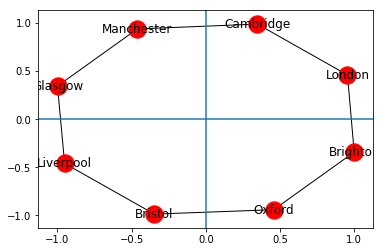

In [21]:
N = 100
iters = 25

max_iters = 100

# create initial population of individuals
individuals = init_population(N)

lastval = None
counter = 0

iter_count = 0

terminated = False


while not terminated and iter_count <= max_iters:
# for iter in range(iters):
    new_individuals = evolve(individuals, N)
    individuals = new_individuals
    
    top = select_top(individuals, 1)[0]
    fitness = top[1]
    
    if lastval == fitness:
        counter += 1
    else:
        counter = 0
        
    iter_count += 1
    
    lastval = fitness
    
    if counter == iters:
        terminated = True
        
    c_str = "(" + str(counter) + "/" + str(iters) + ")" + " (" + str(iter_count) + "/" + str(max_iters) + ")"
    print("fitness:", fitness, c_str)
        
# adequate solution found
solution = select_top(individuals, 1)[0]
path = solution[0]
edges = list(get_edges(path))

print(solution)

graph = nx.Graph()

for n, p in data.items():
    graph.add_node(n)
    graph.node[n]['pos'] = p

graph.add_edges_from(edges)

#plt.grid()


if map_data_type:
    nx.draw_networkx(graph, arrows=True)
else:
    nx.draw_networkx(graph, data, arrows=True)
    
plt.axhline(y=0)
plt.axvline(x=0)
plt.show()

In [ ]:
print(edges)